In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
! pip install tensorflow_addons
import tensorflow_addons as tfa
from keras.models import Sequential

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


###Pre-process Data

In [3]:
import numpy as np
from skimage.util.shape import view_as_windows
from PIL import Image
from matplotlib import pyplot as plt
def preprocess_data():
  train,traing = [],[]
  test1,test1g=[],[]
  test2,test2g=[],[]
  maneesh_path = "/content/drive/MyDrive/Colab Notebooks/SMAI /Project/train400/test_"
  maneesh2_path="/content/drive/MyDrive/Colab Notebooks/SMAI/Project/train400/test_"
  varun_path = "/content/drive/MyDrive/SMAI/Project/train400/test_"
  for i in range(1,401):
    imgName=''
    if i<100:
      if i<10:
        imgName='00'+str(i)
      else:
        imgName='0'+str(i)
    else:
      imgName=str(i)
    file = maneesh2_path+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)
    t = view_as_windows(image, (50,50), step=30).reshape((-1,50,50))  
    train.append(t)

  varun_path = "/content/drive/MyDrive/SMAI/Project/test12/"
  
  maneesh_path = "/content/drive/MyDrive/Colab Notebooks/SMAI /Project/set12/"
  maneesh2_path="/content/drive/MyDrive/Colab Notebooks/SMAI/Project/set12/"

  for i in range(1,8):
    imgName=''
    if i<10:
      imgName='0'+str(i)
    else:
      imgName=str(i)
    # imgName=str(i)
    file = maneesh2_path+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)
    t = view_as_windows(image, (50,50), step=50).reshape((-1,50,50))  
    test1.append(t)

  for i in range(8,13):
    imgName=''
    if i<10:
      imgName='0'+str(i)
    else:
      imgName=str(i)
    # imgName=str(i)
    file = maneesh2_path+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)  
    t = view_as_windows(image, (50,50), step=50).reshape((-1,50,50))
    test2.append(t)

  mean = 0
  sigma = 50

  gauss_noise = np.random.normal(mean,sigma,(50,50))

  train =  np.array(train).reshape((-1,50,50))
  test1 =  np.array(test1).reshape((-1,50,50))
  test2 =  np.array(test2).reshape((-1,50,50))


  traing = train + gauss_noise
  test1g = test1 + gauss_noise
  test2g = test2 + gauss_noise

  train = train/255.0
  traing = traing/255.0
  test1=test1/255.0
  test1g=test1g/255.0
  test2=test2/255.0
  test2g=test2g/255.0

  for i in range(4):
    plt.imshow(train[i],cmap='gray')
    plt.show()
    plt.imshow(traing[i],cmap='gray')
    plt.show()
  for i in range(4):
    plt.imshow(test1[i],cmap='gray')
    plt.show()
    plt.imshow(test1g[i],cmap='gray')
    plt.show()
  
  return train,traing,test1,test1g,test2,test2g

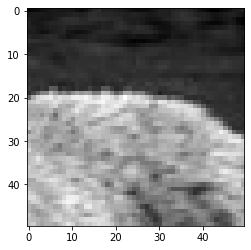

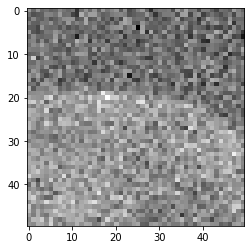

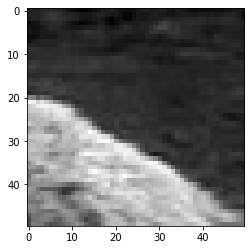

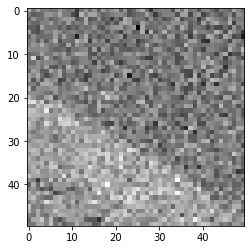

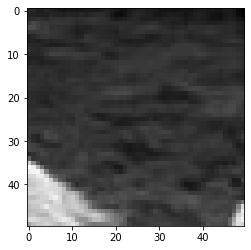

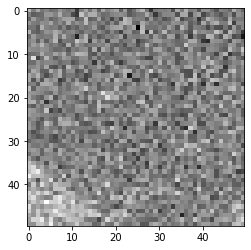

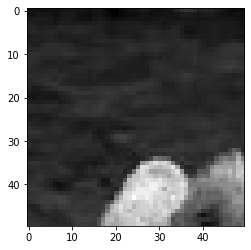

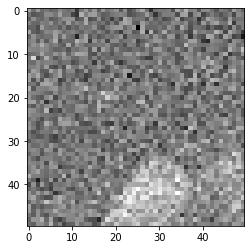

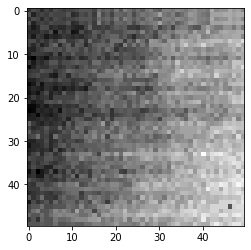

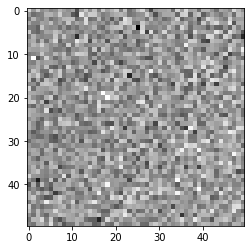

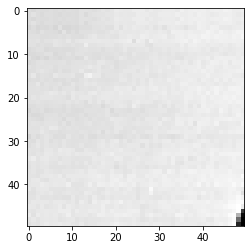

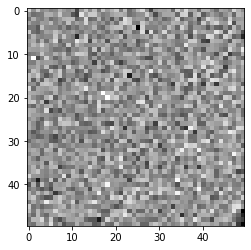

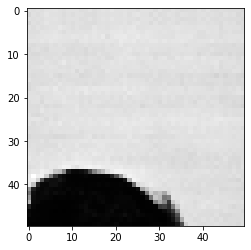

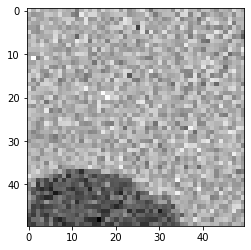

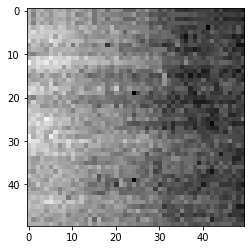

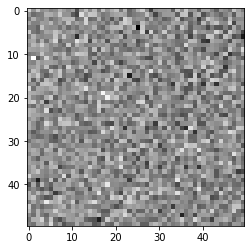

(10000, 50, 50, 1) (10000, 50, 50, 1) (175, 50, 50, 1) (175, 50, 50, 1) (500, 50, 50, 1) (500, 50, 50, 1)


In [4]:
train,traing,test1,test1g,test2,test2g=preprocess_data()

train = np.expand_dims(train,axis=-1)
traing = np.expand_dims(traing,axis=-1)
test1 = np.expand_dims(test1,axis=-1)
test1g = np.expand_dims(test1g,axis=-1)
test2 = np.expand_dims(test2,axis=-1)
test2g = np.expand_dims(test2g,axis=-1)
print(train.shape,traing.shape, test1.shape, test1g.shape,test2.shape, test2g.shape)

In [5]:
print(train.shape,traing.shape, test1.shape, test1g.shape,test2.shape, test2g.shape)

(10000, 50, 50, 1) (10000, 50, 50, 1) (175, 50, 50, 1) (175, 50, 50, 1) (500, 50, 50, 1) (500, 50, 50, 1)


#DBF (DDFN)

###Define Model

In [7]:
initializer = tf.keras.initializers.HeNormal()
initializer_last = tf.keras.initializers.RandomNormal(stddev= 0.001)
# layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

In [8]:
class DBF_FeatureExtraction(tf.keras.Model):
  def __init__(self):
    super(DBF_FeatureExtraction,self).__init__()
    self.conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu",kernel_initializer=initializer)
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu",kernel_initializer=initializer)

    self.conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu",kernel_initializer=initializer)
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu",kernel_initializer=initializer)

  def call(self,input_tensor):
    x=self.conv_block_up(input_tensor)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(input_tensor)
    a=self.conv_block_down(z)

    return tf.keras.layers.Concatenate(axis=-1)([x,y,z,a])

In [9]:
class DBF_FeatureIntegration(tf.keras.Model):
  def __init__(self):
    super(DBF_FeatureIntegration,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(24,(1,1), strides=1,padding="same", activation="relu",kernel_initializer=initializer)
    self.conv_block_up=tf.keras.layers.Conv2D(6,(3,3), strides=1,padding="same", activation="relu",kernel_initializer=initializer)
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(6,(3,3),dilation_rate=2,padding="same",activation="relu",kernel_initializer=initializer)
    self.conv_block_down=tf.keras.layers.Conv2D(6,(3,3), strides=1,padding="same", activation="relu",kernel_initializer=initializer)
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(6,(3,3),dilation_rate=2,padding="same",activation="relu",kernel_initializer=initializer)
    self.conv_block_second=tf.keras.layers.Conv2D(8,(1,1), strides=1,padding="same", activation="relu",kernel_initializer=initializer)
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    x=self.conv_block_up(b)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(b)
    a=self.conv_block_down(z)
    add_first=tf.keras.layers.Concatenate(axis=-1)([x,y,z,a])
    f=self.conv_block_second(add_first)
    return tf.keras.layers.Concatenate(axis=-1)([f,input_tensor])

In [10]:
class DBF_Reconstruction(tf.keras.Model):
  def __init__(self):
    super(DBF_Reconstruction,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="sigmoid",kernel_initializer=initializer_last)
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    return b

###Build Model

In [11]:
from keras.models import Sequential
def DBF(N, train_x,train_y,e_count):
  model = Sequential()

  model.add(DBF_FeatureExtraction())

  for i in range(N):
    model.add(DBF_FeatureIntegration())

  model.add(DBF_Reconstruction())

  opt= tfa.optimizers.AdamW(
      weight_decay=0.0001, 
      learning_rate= 0.001,
      name= 'AdamW',
  )
  model.compile(loss='mse',optimizer=opt)
  results = model.fit(traing, train, epochs=e_count, verbose=1,batch_size=64)
  model.summary()
  return model





###Prediction


In [12]:
DBF_psnr_values=[]

In [13]:
def get_psnr(model,test1g,test2g,test1,test2):
  pred1=model(test1g)
  pred2=model(test2g)
  mseloss1 = ((test1g.shape[0])/(test1g.shape[0]+test2g.shape[0]))*np.mean((pred1-test1)**2)+((test2g.shape[0])/(test1g.shape[0]+test2g.shape[0]))*np.mean((pred2-test2)**2)
  psnr_1 =   10*np.log10(1/mseloss1)
  return psnr_1

In [14]:
model_DBF_3=DBF(3,traing,train,25)

# pred1 = model_DBF_3(test1g)
# pred2 = model_DBF_3(test2g)
# mseloss1 = ((test1.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred1-test1)**2)+((test2.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred2-test2)**2)
# psnr_1 =   10*np.log10(1/mseloss1)
psnr_3=get_psnr(model_DBF_3,test1g,test2g,test1,test2)
print("psnr with DBF model with 3 layers",psnr_3)

Epoch 1/25
157/157 [==============================] - 31s 116ms/step - loss: 0.0157
Epoch 2/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0049
Epoch 3/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0044
Epoch 4/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0040
Epoch 5/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0036
Epoch 6/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0033
Epoch 7/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0032
Epoch 8/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0030
Epoch 9/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0029
Epoch 10/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0028
Epoch 11/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0027
Epoch 12/25
157/157 [==============================] - 18s 114ms/step - lo

In [15]:
DBF_psnr_values.append(psnr_3)

In [16]:
model_DBF_5=DBF(5,traing,train,25)
psnr_5=get_psnr(model_DBF_5,test1g,test2g,test1,test2)
print("psnr with DBF model with 5 layers",psnr_5)
DBF_psnr_values.append(psnr_5)

Epoch 1/25
157/157 [==============================] - 32s 179ms/step - loss: 0.0139
Epoch 2/25
157/157 [==============================] - 28s 179ms/step - loss: 0.0045
Epoch 3/25
157/157 [==============================] - 28s 179ms/step - loss: 0.0039
Epoch 4/25
157/157 [==============================] - 28s 179ms/step - loss: 0.0036
Epoch 5/25
157/157 [==============================] - 28s 178ms/step - loss: 0.0033
Epoch 6/25
157/157 [==============================] - 28s 178ms/step - loss: 0.0031
Epoch 7/25
157/157 [==============================] - 28s 178ms/step - loss: 0.0030
Epoch 8/25
157/157 [==============================] - 28s 178ms/step - loss: 0.0029
Epoch 9/25
157/157 [==============================] - 28s 178ms/step - loss: 0.0027
Epoch 10/25
157/157 [==============================] - 28s 178ms/step - loss: 0.0026
Epoch 11/25
157/157 [==============================] - 28s 178ms/step - loss: 0.0026
Epoch 12/25
157/157 [==============================] - 28s 178ms/step - lo

In [17]:
model_DBF_8=DBF(8,traing,train,25)
psnr_8=get_psnr(model_DBF_8,test1g,test2g,test1,test2)
print("psnr with DBF model with 8 layers",psnr_8)
DBF_psnr_values.append(psnr_8)

Epoch 1/25
157/157 [==============================] - 50s 281ms/step - loss: 0.0132
Epoch 2/25
157/157 [==============================] - 44s 282ms/step - loss: 0.0047
Epoch 3/25
157/157 [==============================] - 44s 282ms/step - loss: 0.0040
Epoch 4/25
157/157 [==============================] - 44s 283ms/step - loss: 0.0034
Epoch 5/25
157/157 [==============================] - 44s 283ms/step - loss: 0.0031
Epoch 6/25
157/157 [==============================] - 44s 281ms/step - loss: 0.0027
Epoch 7/25
157/157 [==============================] - 45s 283ms/step - loss: 0.0025
Epoch 8/25
157/157 [==============================] - 44s 283ms/step - loss: 0.0023
Epoch 9/25
157/157 [==============================] - 44s 280ms/step - loss: 0.0022
Epoch 10/25
157/157 [==============================] - 44s 282ms/step - loss: 0.0021
Epoch 11/25
157/157 [==============================] - 44s 281ms/step - loss: 0.0020
Epoch 12/25
157/157 [==============================] - 44s 281ms/step - lo


**DBF**
```
psnr with DBF model with 3 layers 28.05757158327358
psnr with DBF model with 5 layers 28.451614174811354
psnr with DBF model with 8 layers 30.242933762052772
```
**HE normal**


```
psnr with DBF model with 3 layers 27.1113215177812
psnr with DBF model with 5 layers 29.196663058332955
psnr with DBF model with 8 layers 30.491026400298896
```




Text(0.5, 1.0, '8 layers')

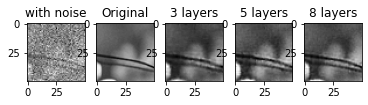

In [18]:
ind=100
fig = plt.figure()
ax = fig.add_subplot(2,3,1)
imgplot = plt.imshow(np.squeeze(test1g[ind],(-1)),cmap='gray')
ax.set_title('with noise')
# plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

ax = fig.add_subplot(2,3, 2)
imgplot = plt.imshow(np.squeeze(test1[ind],(-1)),cmap='gray')
# imgplot.set_clim(0.0, 0.7)
ax.set_title('Original')

temp = np.expand_dims(test1g[ind],axis=0)

pred3 = model_DBF_3(temp)
pred5 = model_DBF_5(temp)
pred8 = model_DBF_8(temp)

pred3 = np.squeeze(pred3,(0,-1))
pred5 = np.squeeze(pred5,(0,-1))
pred8 = np.squeeze(pred8,(0,-1))

ax = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(pred3*256,cmap='gray')
# imgplot.set_clim(0.0, 0.7)
ax.set_title('3 layers')
ax = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(pred5*256,cmap='gray')
# imgplot.set_clim(0.0, 0.7)
ax.set_title('5 layers')
ax = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(pred8*256,cmap='gray')
# imgplot.set_clim(0.0, 0.7)
ax.set_title('8 layers')

# plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

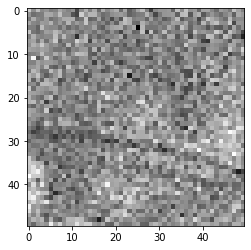

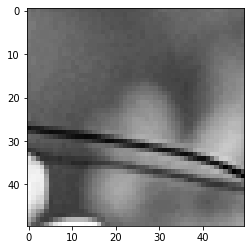

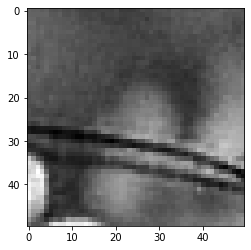

In [19]:
ind=100

plt.imshow(np.squeeze(test1g[ind],(-1)),cmap='gray')
plt.show()

plt.imshow(np.squeeze(test1[ind],(-1)),cmap='gray')
plt.show()

temp = np.expand_dims(test1g[ind],axis=0)

pred3 = model_DBF_3(temp)
pred5 = model_DBF_5(temp)
pred8 = model_DBF_8(temp)

pred = np.squeeze(pred8,(0,-1))

plt.imshow(pred*256,cmap='gray')
plt.show()

###DBF without wide (N layers)

In [20]:
initializer = tf.keras.initializers.HeNormal()
initializer_last = tf.keras.initializers.RandomNormal(stddev= 0.001)

In [21]:
class FeatureExtraction(tf.keras.Model):
  def __init__(self):
    super(FeatureExtraction,self).__init__()
    self.conv_block_up=tf.keras.layers.Conv2D(16,(3,3), padding="same", strides=1, activation="relu",kernel_initializer=initializer)
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(16,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu",kernel_initializer=initializer)

  def call(self,input_tensor):
    x=self.conv_block_up(input_tensor)
    y=self.dilated_conv_block_up(x)
    return tf.keras.layers.Concatenate(axis=-1)([x,y])

In [22]:
class FeatureIntegration(tf.keras.Model):
  def __init__(self):
    super(FeatureIntegration,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(32,(1,1), strides=1,padding="same", activation="relu",kernel_initializer=initializer)
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3),dilation_rate=2,padding="same",activation="relu",kernel_initializer=initializer)
    
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    y=self.dilated_conv_block_up(b)
    return tf.keras.layers.Concatenate(axis=-1)([input_tensor,y])

In [23]:
class Reconstruction(tf.keras.Model):
  def __init__(self):
    super(Reconstruction,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="sigmoid",kernel_initializer=initializer_last)
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    return b

In [24]:
def get_DBF_non_wide(N,train_x,train_y,e_count):
  model = Sequential()

  model.add(FeatureExtraction())

  for i in range(N):
   model.add(FeatureIntegration())

  model.add(Reconstruction())

  opt= tfa.optimizers.AdamW(
    weight_decay=0.0001,
    learning_rate= 0.001,
    name= 'AdamW')
  
  model.compile(loss='mse',optimizer=opt)
  results = model.fit(train_x,train_y, epochs=e_count, verbose=1,batch_size=64)
  model.summary()
  return model

In [25]:
traing.shape,train.shape

((10000, 50, 50, 1), (10000, 50, 50, 1))

In [26]:
DDFN_psnr_values=[]

In [28]:
model3=get_DBF_non_wide(3,traing,train,25)
psnr_DDFN_3=get_psnr(model3,test1g,test2g,test1,test2)
print("psnr with DBF model with 3 layers",psnr_DDFN_3)
DDFN_psnr_values.append(psnr_DDFN_3)

Epoch 1/25
157/157 [==============================] - 14s 73ms/step - loss: 0.0163
Epoch 2/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0054
Epoch 3/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0047
Epoch 4/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0044
Epoch 5/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0041
Epoch 6/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0039
Epoch 7/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0037
Epoch 8/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0035
Epoch 9/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0034
Epoch 10/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0033
Epoch 11/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0032
Epoch 12/25
157/157 [==============================] - 11s 71ms/step - loss: 0.0032
E

In [29]:
model5=get_DBF_non_wide(5,traing,train,25)
psnr_DDFN_5=get_psnr(model5,test1g,test2g,test1,test2)
print("psnr with DBF model with 5 layers",psnr_DDFN_5)
DDFN_psnr_values.append(psnr_DDFN_5)

Epoch 1/25
157/157 [==============================] - 19s 109ms/step - loss: 0.0148
Epoch 2/25
157/157 [==============================] - 17s 108ms/step - loss: 0.0053
Epoch 3/25
157/157 [==============================] - 17s 109ms/step - loss: 0.0045
Epoch 4/25
157/157 [==============================] - 17s 109ms/step - loss: 0.0040
Epoch 5/25
157/157 [==============================] - 17s 108ms/step - loss: 0.0037
Epoch 6/25
157/157 [==============================] - 17s 108ms/step - loss: 0.0035
Epoch 7/25
157/157 [==============================] - 17s 108ms/step - loss: 0.0033
Epoch 8/25
157/157 [==============================] - 17s 108ms/step - loss: 0.0032
Epoch 9/25
157/157 [==============================] - 17s 108ms/step - loss: 0.0031
Epoch 10/25
157/157 [==============================] - 17s 108ms/step - loss: 0.0030
Epoch 11/25
157/157 [==============================] - 17s 108ms/step - loss: 0.0029
Epoch 12/25
157/157 [==============================] - 17s 109ms/step - lo

In [30]:
model8=get_DBF_non_wide(8,traing,train,25)
psnr_DDFN_8=get_psnr(model8,test1g,test2g,test1,test2)
print("psnr with DBF model with 8 layers",psnr_DDFN_8)
DDFN_psnr_values.append(psnr_DDFN_8)
# pred1 = model8(test1g)
# pred2 = model8(test2g)
# # print(pred.shape,test.shape)

Epoch 1/25
157/157 [==============================] - 29s 170ms/step - loss: 0.0132
Epoch 2/25
157/157 [==============================] - 26s 169ms/step - loss: 0.0049
Epoch 3/25
157/157 [==============================] - 26s 169ms/step - loss: 0.0043
Epoch 4/25
157/157 [==============================] - 26s 169ms/step - loss: 0.0039
Epoch 5/25
157/157 [==============================] - 26s 168ms/step - loss: 0.0035
Epoch 6/25
157/157 [==============================] - 26s 168ms/step - loss: 0.0033
Epoch 7/25
157/157 [==============================] - 26s 168ms/step - loss: 0.0031
Epoch 8/25
157/157 [==============================] - 26s 168ms/step - loss: 0.0030
Epoch 9/25
157/157 [==============================] - 26s 168ms/step - loss: 0.0028
Epoch 10/25
157/157 [==============================] - 26s 168ms/step - loss: 0.0027
Epoch 11/25
157/157 [==============================] - 26s 168ms/step - loss: 0.0026
Epoch 12/25
157/157 [==============================] - 26s 168ms/step - lo


**DDFN**
```

psnr with DBF model with 3 layers 26.657159230337946
psnr with DBF model with 5 layers 28.00920732588073
psnr with DBF model with 8 layers 29.56689984279704
```

**HE, normal**


```
psnr with DBF model with 3 layers 27.24416271172979
psnr with DBF model with 5 layers 28.23621166838089
psnr with DBF model with 8 layers 29.446003538705135
```





In [40]:
DBF_psnr_values,DDFN_psnr_values

([27.1113215177812, 29.196663058332955, 30.491026400298896],
 [27.24416271172979, 28.23621166838089, 29.446003538705135])

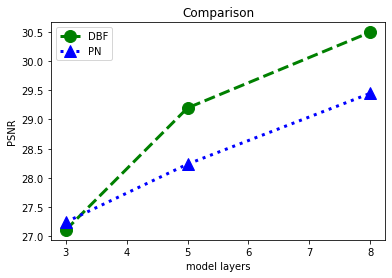

In [46]:
import matplotlib.pyplot as plt

# plotting the points
plt.plot([3,5,8], DBF_psnr_values, color='green', linestyle='dashed', linewidth = 3,
		marker='o', markerfacecolor='green', markersize=12,label = "DBF")

plt.plot([3,5,8], DDFN_psnr_values, color='blue', linestyle='dotted', linewidth = 3,
		marker='^', markerfacecolor='blue', markersize=12,label = "PN")

# naming the x axis
plt.xlabel('model layers')
# naming the y axis
plt.ylabel('PSNR')

# giving a title to my graph
plt.title('Comparison')

# show a legend on the plot
plt.legend()

plt.savefig("Comparison.png")

# function to show the plot
plt.show()

In [ ]:
import pickle
# with open('/content/drive/MyDrive/Colab Notebooks/SMAI /Project/model_500.pickle', 'wb') as f:
#     pickle.dump(model, f)

# with open('/content/drive/MyDrive/Colab Notebooks/SMAI /Project/model_500.pickle', 'rb') as f:
#     model = pickle.load(f)

INFO:tensorflow:Assets written to: ram://9df2cf48-8f21-4c02-b814-b4a402a8c126/assets
